In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import csv
%matplotlib inline

### Load & Format data

Used data from 08/2012 to 12/2013

In [ ]:
files = glob('./*.txt')
data = []
for file in files[69:71]:
    with open(file,'rt') as f:
        reader = csv.reader((line.replace('\0','') for line in f),delimiter = ',', quotechar = '"')
        data += [row for row in reader]

In [ ]:
locs = {}
for d in data:
    location = d[0]+' '+d[1]+' '+d[2]
    
    if location not in locs:
        locs[location] = np.array(d[3:]).reshape(-1,5)
    #for n in np.array(d[3:]).reshape(-1,5):
    locs[location] = np.vstack((locs[location],np.array(d[3:]).reshape(-1,5)))

In [ ]:
for location in locs.keys():    
    locs[location] = np.array([np.append(l,location) for l in locs[location]])

In [ ]:
a = pd.DataFrame(np.concatenate(list(locs.values())),columns = ['date','time','disc','entries','exits','location'])

In [ ]:
a.to_csv('2013_data_full.csv',index = False)

### Preprocessing

add date/time/location features, drop abnormal data points

In [ ]:
# merge and add features
data = pd.read_csv('2013_data_full.csv')
data[['entries','exits']] = data[['entries','exits']].apply(pd.to_numeric)
data['datetime'] = data['date']+' '+data['time']
f = '%m-%d-%y %H:%M:%S'
data['dt'] = data['datetime'].apply(lambda x: datetime.strptime(x,f))
data['Booth'] = data['location'].apply(lambda x: x.split(' ')[0])
data['Remote'] = data['location'].apply(lambda x: x.split(' ')[1])
code_map = pd.read_csv('Remote-Booth-Station.csv')
df_merge = pd.merge(data,code_map,on = ['Remote','Booth'])
df_merge = df_merge.sort_values(['Station','location','dt']).reset_index()
df_merge['entries_change'] = df_merge.groupby(['location','Station'])['entries'].apply(lambda x:x.diff(+1))
df_merge['exits_change'] = df_merge.groupby(['location','Station'])['exits'].apply(lambda x:x.diff(+1))
df_merge['month'] = df_merge['dt'].apply(lambda x: x.month)
df_merge['dayofweek'] = df_merge['dt'].apply(lambda x: x.dayofweek)
df_merge['dayofmonth'] = df_merge['dt'].apply(lambda x:x.day)
df_merge['weekofyear'] = df_merge['dt'].apply(lambda x:x.weekofyear)
df_merge['dayofyear'] = df_merge['dt'].apply(lambda x: x.dayofyear)
df_merge['hour'] = df_merge['dt'].apply(lambda x:x.hour)

In [ ]:
#get REGULAR rows with 4hour interval
t = ['0','4','8','12','16','20']
df_regular = df_merge[(df_merge['hour'].isin(t)) & (df_merge['disc'] == 'REGULAR')]
df_regular = df_regular.dropna()

In [ ]:
#drop outliers
outlier_1 = df_regular[df_regular['entries_change']<0].index.tolist()
outlier_2 = df_regular[df_regular['exits_change']<0].index.tolist()
outlier_3 = df_regular[df_regular['entries_change']>5000].index.tolist()
outlier_4 = df_regular[df_regular['exits_change']>5000].index.tolist()
outliers = outlier_1+outlier_2+outlier_3+outlier_4
df_regular = df_regular.drop(outliers,axis = 0)

In [ ]:
#Save
df_regular=pd.read_csv('2013_regular.csv')

### Modeling

- Question asks to develop a model for 4hr-interval exit count by turnstile device, however, with over 4000 differnet devices, the dataset became too large to run for my laptop. Since the next question asked prediction for a Remote. I develop a model by Remote instead of device. 

- The model is based on 7 features: remote, hour of the day, day of the week, day of the month, day of the year,week of the year and month. Base on the feature importance plot, hour of the day and day of the week are the two most important feature. 

- The performance of the current model based on the R_score was alright (>0.9), the mean_square_error is large. By ploting the actual value and predicted value, it seem the model got the general pattern of changes but is not good at predicting higher counts. Due to the limitation of time and computational power of my laptop, I was not able to run GridSearch for a hyperparameter tuning.(training once with current model takes over 5 hours on my laptop...).If I have more time, I could set it up on AWS or other cloud computing engine, but it is not possible for now.

- To improve the model perfomance:
  - train on more data: train with all 7 years of data. with only one year of data, the annual or seasonal pattern is not picked up.
  - fine tune the hyperparameters with grid search, more iterations.
  - maybe better to try with less feature, since from the feature importance plot hour and day of week are the most important ones, train with only these two might give us better predictions.
  - More data cleaning: from the plot, R195 was not functioning in full capacity for quite some time in 2012, that might interfered with our prediction. it should be take out. And I could image many of the Remote data have the same problem.
  - RNN network.
  - the best model might be train on Remotes that are closely located to R192 and predict. 
  
##### R195 prediction
the current model predict 8699 exits on Friday September 6, 2013 while the actual number is 14984. as discussed previously, the model is not performing well with high counts.

In [2]:
df_regular=pd.read_csv('2013_regular.csv')
df = df_regular.groupby(['Remote','month','dayofweek','dayofmonth','weekofyear','dayofyear','hour','dt'])['exits_change'].sum().reset_index()

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from sklearn.preprocessing import StandardScaler
features = ['month','dayofweek','dayofmonth','weekofyear','dayofyear','hour']
sds = StandardScaler()
X = sds.fit_transform(df[features])
X = pd.DataFrame(X,columns = features)
y = df['exits_change']

In [4]:
remote =pd.get_dummies(df['Remote'])
X = pd.concat((X,remote),axis = 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [6]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train,feature_names=X_train.columns.values)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-rmse:2391.19	test-rmse:2391.87
[50]	train-rmse:1395.8	test-rmse:1414.27
[100]	train-rmse:1160.44	test-rmse:1189.79
[150]	train-rmse:1017.27	test-rmse:1055.86
[200]	train-rmse:917.165	test-rmse:965.544
[250]	train-rmse:841.978	test-rmse:898.191
[300]	train-rmse:784.883	test-rmse:849.308
[350]	train-rmse:739.382	test-rmse:811.306
[400]	train-rmse:701.439	test-rmse:779.824
[450]	train-rmse:667.946	test-rmse:753.001
[500]	train-rmse:639.541	test-rmse:730.914
[550]	train-rmse:615.063	test-rmse:711.997
[600]	train-rmse:593.12	test-rmse:695.125
[650]	train-rmse:572.892	test-rmse:680.337
[700]	train-rmse:554.206	test-rmse:666.988
[750]	train-rmse:538.559	test-rmse:655.654
[800]	train-rmse:522.746	test-rmse:645.123
[850]	train-rmse:508.973	test-rmse:635.657
[900]	train-rmse:495.697	test-rmse:626.807
[950]	train-rmse:483.655	test-rmse:619.021


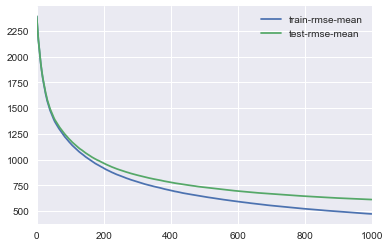

In [7]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()


In [8]:
model_1 = xgb.train(xgb_params, dtrain, num_boost_round=1000)

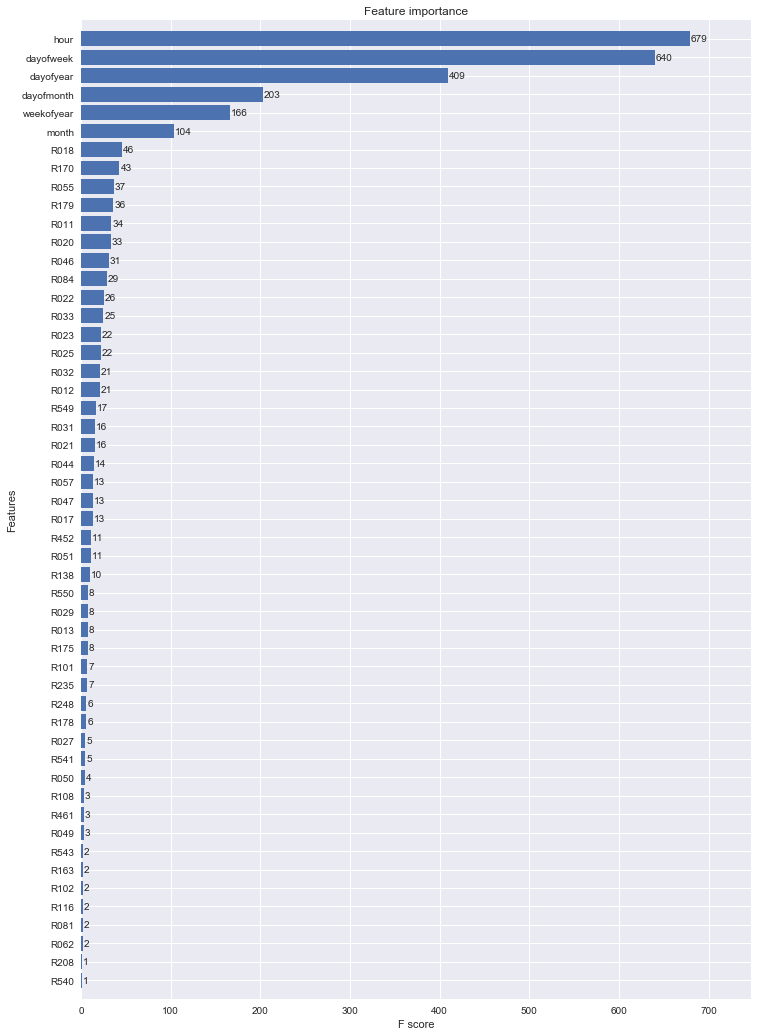

In [25]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_1,height=0.8, ax=ax)

In [9]:
dtest = xgb.DMatrix(X_test)
dxtrain = xgb.DMatrix(X_train)
pred = model_1.predict(dtest)
pred_t = model_1.predict(dxtrain)

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
mean_squared_error(y_test,pred)

367743.11297375523

In [11]:
r2_score(y_test,pred)

0.92476701113757687

In [12]:
mean_squared_error(y_train,pred_t)

237880.23299553694

In [13]:
r2_score(y_train,pred_t)

0.95031308063266062

In [200]:
from sklearn.grid_search import GridSearchCV 
from xgboost.sklearn import XGBRegressor
param_test1 = {
 'max_depth':list(range(4,12,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=10, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'reg:linear', scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


([mean: -5570725.34145, std: 46713.08001, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -5570601.13679, std: 46530.89975, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -5570595.00134, std: 46371.09924, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -5366977.87448, std: 39881.37509, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -5366963.78627, std: 39485.39444, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -5367251.41439, std: 39386.89861, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -5198079.16152, std: 35530.97550, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: -5197347.19137, std: 36945.96036, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -5197360.67851, std: 37250.50395, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -5073250.61265, std: 34240.76021, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: -5073253.97061, std: 33676.89389, params: {'max_depth': 10, 'min_child_weight': 3

### Plot performance

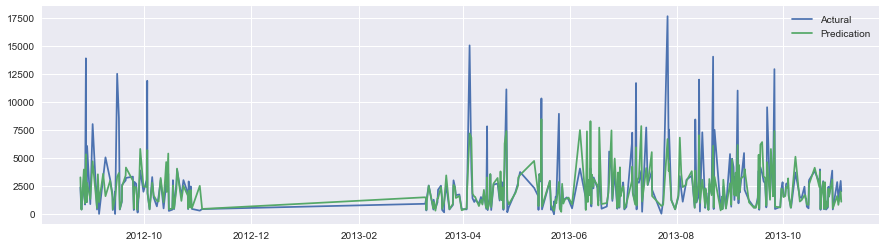

In [28]:
test_pred = df.loc[y_test.index.values,:]
test_pred['pred'] = pred
test_pred_195 = test_pred[test_pred['Remote']=='R195'].sort_values('dt')
date_time = matplotlib.dates.datestr2num(test_pred_195['dt'].tolist())
plt.figure(figsize = (15,4))
plt.plot_date(date_time,test_pred_195['exits_change'],'-')
plt.plot_date(date_time,test_pred_195['pred'],'-')
plt.legend(['Actural','Predication'])

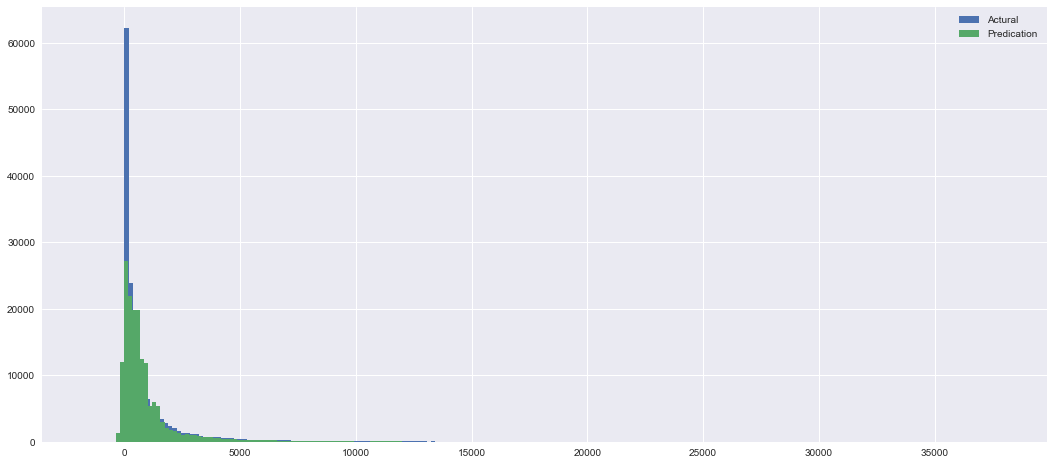

In [27]:
plt.figure(figsize = (18,8))
plt.hist(y_test,bins = 200)
plt.hist(pred,bins = 200)
plt.legend(['Actural','Predication'])
plt.show()

### Predict R195

In [14]:
R195_idx = df[(df['Remote'] =='R195')&\
              (df['month'] == 9)&\
              (df['dayofweek']==4)&\
              (df['dayofmonth']==6)&\
              (df['hour']==20)].index.values
test_r195 = xgb.DMatrix(np.array(X_train.loc[R195_idx,:]).reshape(1,472),\
                        feature_names=X_train.columns.values)
model_1.predict(test_r195)

array([ 8699.36230469], dtype=float32)

In [15]:
R195_idx = df[(df['Remote'] =='R195')&\
              (df['month'] == 9)&\
              (df['dayofweek']==3)&\
              (df['hour']==16)].index.values
test_r195 = xgb.DMatrix(np.array(X_train.loc[R195_idx,:]).reshape(-1,472),\
                        feature_names=X_train.columns.values)
model_1.predict(test_r195)

array([  380.90924072,  4370.39257812,  2987.76513672,  2986.34204102,
         380.90924072,   380.90924072,  3507.65942383,  2979.68432617], dtype=float32)

In [16]:
df[(df['Remote'] =='R195')&\
              (df['month'] == 9)&\
              (df['dayofweek']==3)&\
              (df['hour']==16)]

,Remote,month,dayofweek,dayofmonth,weekofyear,dayofyear,hour,dt,exits_change
279314,R195,9,3,5,36,248,16,2013-09-05 16:22:00,2890.0
279320,R195,9,3,6,36,250,16,2012-09-06 16:22:00,3280.0
279326,R195,9,3,12,37,255,16,2013-09-12 16:22:00,3139.0
279332,R195,9,3,13,37,257,16,2012-09-13 16:22:00,3153.0
279338,R195,9,3,19,38,262,16,2013-09-19 16:22:00,2912.0
279342,R195,9,3,20,38,264,16,2012-09-20 16:22:00,3208.0
279348,R195,9,3,26,39,269,16,2013-09-26 16:22:00,3779.0
279356,R195,9,3,27,39,271,16,2012-09-27 16:22:00,3102.0
